In [51]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_absolute_error
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


In [2]:
df = pd.read_csv("../archive/preprocessed_data.csv",sep=",", parse_dates=["Start", "End"])

In [3]:
df = df.drop(columns=["start_hour", "end_hour", "sleep_hour", "wake_hour","sleep_sin","sleep_cos","wake_sin","wake_cos","Time in bed"])

In [4]:
df

,Start,End,Sleep quality,Activity (steps),time_in_minutes,sleep_hour_adj,sleep_timing_bin,Day
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,0,512,22.950000,Typical,Tuesday
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0,16,21.283333,Typical,Tuesday
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,0,510,22.700000,Typical,Wednesday
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,0,452,22.516667,Typical,Thursday
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,0,404,22.200000,Typical,Friday
...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,56,548,21.900000,Typical,Tuesday
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,64,431,23.816667,Typical,Wednesday
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,3316,536,21.400000,Typical,Thursday
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,6555,553,21.600000,Typical,Friday


In [5]:
df

,Start,End,Sleep quality,Activity (steps),time_in_minutes,sleep_hour_adj,sleep_timing_bin,Day
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,0,512,22.950000,Typical,Tuesday
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0,16,21.283333,Typical,Tuesday
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,0,510,22.700000,Typical,Wednesday
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,0,452,22.516667,Typical,Thursday
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,0,404,22.200000,Typical,Friday
...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,56,548,21.900000,Typical,Tuesday
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,64,431,23.816667,Typical,Wednesday
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,3316,536,21.400000,Typical,Thursday
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,6555,553,21.600000,Typical,Friday


In [6]:
#Sort by time
df = df.sort_values("Start").reset_index(drop=True)

target = "Sleep quality"
lags = [1, 2, 3, 7]

Create lagged features
df_feat = df.copy()

In [7]:
df_feat

,Start,End,Sleep quality,Activity (steps),time_in_minutes,sleep_hour_adj,sleep_timing_bin,Day
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,0,512,22.950000,Typical,Tuesday
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0,16,21.283333,Typical,Tuesday
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,0,510,22.700000,Typical,Wednesday
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,0,452,22.516667,Typical,Thursday
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,0,404,22.200000,Typical,Friday
...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,56,548,21.900000,Typical,Tuesday
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,64,431,23.816667,Typical,Wednesday
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,3316,536,21.400000,Typical,Thursday
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,6555,553,21.600000,Typical,Friday


In [8]:
split_point = int(df_feat.shape[0] * 0.8)

df_feat_train = df_feat.iloc[:split_point]
df_feat_test = df_feat.iloc[split_point:]

# X_train = X.iloc[:split_point]
# y_train = y.iloc[:split_point]

# X_test = X.iloc[split_point:]
# y_test = y.iloc[split_point:]

In [9]:
# Lag the target variable (yesterday's sleep quality, etc.)
for lag in lags:
    df_feat_train[f"{target}_lag{lag}"] = df_feat_train[target].shift(lag)

# Lag the predictors (use PREVIOUS days' activity and timing)
base_vars = ["time_in_minutes", "Activity (steps)", "sleep_timing_bin", "Day"]
for col in base_vars:
    for lag in lags:
        df_feat_train[f"{col}_lag{lag}"] = df_feat_train[col].shift(lag)


# Drop rows with NaN in lagged features
# Only keep rows where all lagged features are available
lag_feature_cols = [f"{target}_lag{l}" for l in lags]
for col in base_vars:
    lag_feature_cols += [f"{col}_lag{l}" for l in lags]

df_feat_train = df_feat_train.dropna(subset=[target] + lag_feature_cols).reset_index(drop=True)

# Define features 
# Numeric lagged features
lag_num = [f"{target}_lag{l}" for l in lags]
for col in ["time_in_minutes", "Activity (steps)"]:
    lag_num += [f"{col}_lag{l}" for l in lags]

# Categorical lagged features
lag_cat = []
for col in ["sleep_timing_bin", "Day"]:
    lag_cat += [f"{col}_lag{l}" for l in lags]

# All features are lagged
feature_cols = lag_num + lag_cat

X = df_feat_train[feature_cols]
y = df_feat_train[target]


print(f"Shape after feature engineering: X={X.shape}, y={y.shape}")
print(feature_cols)

# Preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), lag_num),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), lag_cat),
    ],
    remainder="drop"
)


# Models
gbm = HistGradientBoostingRegressor()

rf = RandomForestRegressor()

pipelines = {
    "GBM": Pipeline(steps=[("prep", preprocess), ("model", gbm)]),
    "RF":  Pipeline(steps=[("prep", preprocess), ("model", rf)]),
}


# Time-series CV 
tscv = TimeSeriesSplit(n_splits=5)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": "r2"
}

#Evaluate
results = []
for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    cv = cross_validate(
        pipe, X, y,
        cv=tscv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    results.append({
        "model": name,
        "MAE_mean": -cv["test_MAE"].mean(),
        "MAE_std":  cv["test_MAE"].std(),
        "R2_mean":  cv["test_R2"].mean(),
        "R2_std":   cv["test_R2"].std(),
    })

results_df = pd.DataFrame(results).sort_values("MAE_mean")
results_df
# print(results_df.to_string(index=False))



Shape after feature engineering: X=(702, 20), y=(702,)
['Sleep quality_lag1', 'Sleep quality_lag2', 'Sleep quality_lag3', 'Sleep quality_lag7', 'time_in_minutes_lag1', 'time_in_minutes_lag2', 'time_in_minutes_lag3', 'time_in_minutes_lag7', 'Activity (steps)_lag1', 'Activity (steps)_lag2', 'Activity (steps)_lag3', 'Activity (steps)_lag7', 'sleep_timing_bin_lag1', 'sleep_timing_bin_lag2', 'sleep_timing_bin_lag3', 'sleep_timing_bin_lag7', 'Day_lag1', 'Day_lag2', 'Day_lag3', 'Day_lag7']

Training GBM...


/var/folders/mt/mxjgxl111qq30xtvb88fksnw0000gn/T/ipykernel_69231/1613396897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_train[f"{target}_lag{lag}"] = df_feat_train[target].shift(lag)
/var/folders/mt/mxjgxl111qq30xtvb88fksnw0000gn/T/ipykernel_69231/1613396897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_train[f"{target}_lag{lag}"] = df_feat_train[target].shift(lag)
/var/folders/mt/mxjgxl111qq30xtvb88fksnw0000gn/T/ipykernel_69231/1613396897.py:3: SettingWithCopyWarning: 
A value


Training RF...


,model,MAE_mean,MAE_std,R2_mean,R2_std
1,RF,12.845556,3.776366,-0.216923,0.173255
0,GBM,13.029075,2.794839,-0.249423,0.119270


In [10]:
X.shape

(702, 20)

In [11]:
X.columns

Index(['Sleep quality_lag1', 'Sleep quality_lag2', 'Sleep quality_lag3',
       'Sleep quality_lag7', 'time_in_minutes_lag1', 'time_in_minutes_lag2',
       'time_in_minutes_lag3', 'time_in_minutes_lag7', 'Activity (steps)_lag1',
       'Activity (steps)_lag2', 'Activity (steps)_lag3',
       'Activity (steps)_lag7', 'sleep_timing_bin_lag1',
       'sleep_timing_bin_lag2', 'sleep_timing_bin_lag3',
       'sleep_timing_bin_lag7', 'Day_lag1', 'Day_lag2', 'Day_lag3',
       'Day_lag7'],
      dtype='object')

We can see that the random forest model performed better. A mean absolute error of 12 is relatively fair, meaning the predicted sleep quality is within 12 units of the actual figure. A r squared of 0.2 might be relatively weak, but expected in such sleep studies without clinical variables.

### Hyperparameter tuning

In [12]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

# Hyperparameter search space
rf_param_dist = {
    "model__n_estimators": [300, 500, 800, 1200],
    "model__max_depth": [None, 6, 10, 14, 18, 24],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
}


# Time-series CV + scorer
tscv = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Randomized search
rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=40,              # increase for deeper search
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Tuning Random Forest...")
rf_search.fit(X, y)

print("\nBest RF MAE (CV):", -rf_search.best_score_)
print("Best RF parameters:")
for k, v in rf_search.best_params_.items():
    print(f"  {k}: {v}")


# Final evaluation of tuned RF
cv_results = cross_validate(
    rf_search.best_estimator_,
    X, y,
    cv=tscv,
    scoring={"MAE": mae_scorer, "R2": "r2"},
    n_jobs=-1,
    return_train_score=False
)

results_df = pd.DataFrame({
    "MAE_mean": [-cv_results["test_MAE"].mean()],
    "MAE_std":  [cv_results["test_MAE"].std()],
    "R2_mean":  [cv_results["test_R2"].mean()],
    "R2_std":   [cv_results["test_R2"].std()],
})

results_df

Tuning Random Forest...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best RF MAE (CV): 11.474049543980291
Best RF parameters:
  model__n_estimators: 800
  model__min_samples_split: 20
  model__min_samples_leaf: 20
  model__max_features: log2
  model__max_depth: 24


,MAE_mean,MAE_std,R2_mean,R2_std
0,11.47405,2.47753,-0.082653,0.109228


After hyperparameter tuning, we see that the MAE comes down to about 11 MAE

## Single prediction

In [13]:
best_rf_pipe = rf_search.best_estimator_

In [14]:
best_rf_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

Now we make a prediction using a datapoint of the X_test

In [15]:
#Save model
with open('sleep_model.bin', 'wb') as f_out:
    pickle.dump(best_rf_pipe, f_out)

In [16]:
#Load model
with open('sleep_model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

In [17]:
pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [18]:
def build_lagged_row_shift_style(
    history_df: pd.DataFrame,
    # feature_cols: list[str],
    lags=(1, 2, 3, 7),
    target="Sleep quality",
    base_vars=("time_in_minutes", "Activity (steps)", "sleep_timing_bin", "Day"),
    time_col="Start",
):
    """
    Builds lag features using df.shift() exactly like the training code,
    then returns the latest single-row feature vector for prediction.

    history_df: data available up to (and including) the most recent COMPLETED record.
                Must contain target + base_vars + time_col.
    feature_cols: exact training feature columns (X.columns).
    """
    df_feat = history_df.sort_values(time_col).reset_index(drop=True).copy()

    # ---
    for lag in lags:
        df_feat[f"{target}_lag{lag}"] = df_feat[target].shift(lag)

    for col in base_vars:
        for lag in lags:
            df_feat[f"{col}_lag{lag}"] = df_feat[col].shift(lag)


    lag_feature_cols = [f"{target}_lag{l}" for l in lags]
    for col in base_vars:
        lag_feature_cols += [f"{col}_lag{l}" for l in lags]

    # In production you usually don't require current target to exist for the row you predict.
    # But since we're predicting the NEXT step using the last completed record, target exists in history anyway.
    df_feat = df_feat.dropna(subset=[target] + lag_feature_cols).reset_index(drop=True)

    if df_feat.empty:
        raise ValueError("Not enough history to construct lag features (need at least max(lags)+1 rows).")

    # Take the most recent row's lag features as a single prediction input
    # X_one = df_feat.iloc[[-1]][feature_cols].copy()
    X_one = df_feat.iloc[[-1]].copy()

    return X_one


We see that in our dataframe, the time_in_minutes, sleep_timing_bin, and Day were already extracted as batch. In practical terms, a preprocessing step to extract these features might also be included.

In [19]:
feature_cols = ['Sleep quality_lag1', 'Sleep quality_lag2', 'Sleep quality_lag3',
       'Sleep quality_lag7', 'time_in_minutes_lag1', 'time_in_minutes_lag2',
       'time_in_minutes_lag3', 'time_in_minutes_lag7', 'Activity (steps)_lag1',
       'Activity (steps)_lag2', 'Activity (steps)_lag3',
       'Activity (steps)_lag7', 'sleep_timing_bin_lag1',
       'sleep_timing_bin_lag2', 'sleep_timing_bin_lag3',
       'sleep_timing_bin_lag7', 'Day_lag1', 'Day_lag2', 'Day_lag3',
       'Day_lag7']

In [20]:
X_prev_8 = df_feat_test.iloc[8:16] 
X_prev_8[["Start", "Sleep quality"]]






,Start,Sleep quality
717,2017-07-25 22:04:25,87.0
718,2017-07-26 22:29:46,74.0
719,2017-07-27 21:53:02,51.0
720,2017-07-28 23:29:02,38.0
721,2017-07-29 22:00:52,72.0
722,2017-07-30 23:20:22,89.0
723,2017-07-31 22:39:28,82.0
724,2017-08-01 23:15:08,77.0


In [21]:
X_prev_8

,Start,End,Sleep quality,Activity (steps),time_in_minutes,sleep_hour_adj,sleep_timing_bin,Day
717,2017-07-25 22:04:25,2017-07-26 05:48:19,87.0,5451,463,22.066667,Typical,Wednesday
718,2017-07-26 22:29:46,2017-07-27 06:05:30,74.0,2899,455,22.483333,Typical,Thursday
719,2017-07-27 21:53:02,2017-07-28 05:50:03,51.0,1552,477,21.883333,Typical,Friday
720,2017-07-28 23:29:02,2017-07-29 06:22:28,38.0,5221,413,23.483333,Typical,Saturday
721,2017-07-29 22:00:52,2017-07-30 06:50:26,72.0,3834,529,22.000000,Typical,Sunday
722,2017-07-30 23:20:22,2017-07-31 06:33:10,89.0,1018,432,23.333333,Typical,Monday
723,2017-07-31 22:39:28,2017-08-01 06:19:20,82.0,1837,459,22.650000,Typical,Tuesday
724,2017-08-01 23:15:08,2017-08-02 06:10:05,77.0,893,414,23.250000,Typical,Wednesday


In [22]:

X_single = build_lagged_row_shift_style(X_prev_8)


In [23]:
#To make sure the the features match with the training features and there is no leakage
X_single = X_single[feature_cols]

In [24]:
X_single.shape

(1, 20)

In [25]:
X_single

,Sleep quality_lag1,Sleep quality_lag2,Sleep quality_lag3,Sleep quality_lag7,time_in_minutes_lag1,time_in_minutes_lag2,time_in_minutes_lag3,time_in_minutes_lag7,Activity (steps)_lag1,Activity (steps)_lag2,Activity (steps)_lag3,Activity (steps)_lag7,sleep_timing_bin_lag1,sleep_timing_bin_lag2,sleep_timing_bin_lag3,sleep_timing_bin_lag7,Day_lag1,Day_lag2,Day_lag3,Day_lag7
0,82.0,89.0,72.0,87.0,459.0,432.0,529.0,463.0,1837.0,1018.0,3834.0,5451.0,Typical,Typical,Typical,Typical,Tuesday,Monday,Sunday,Wednesday


In [26]:
prediction = float(pipeline.predict(X_single))
prediction

/var/folders/mt/mxjgxl111qq30xtvb88fksnw0000gn/T/ipykernel_69231/2804992064.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(pipeline.predict(X_single))


75.40131819717689

In [27]:
# prediction = float(pipeline.predict(X_single))
# prediction

In [28]:
# Compare to actual value of row 16
actual = float(df_feat_test["Sleep quality"].iloc[16])
actual

81.0

We see that the prediction is close to the actual value, off by about 6 units

In [29]:
df_feat_test["Start"].iloc[16]

Timestamp('2017-08-02 22:32:50')

### Feature Importance

This is to check which features contributed the most to prediction

In [42]:
rf_model = pipeline.named_steps["model"]


In [45]:
importances = rf_model.feature_importances_



In [48]:
pre = pipeline.named_steps["prep"]

encoded_feature_names = pre.get_feature_names_out()

In [44]:

len(importances)

56

In [40]:
len(feature_cols)

20

In [49]:
importance_df = (pd.DataFrame({"feature": encoded_feature_names,"importance": importances}).sort_values("importance", ascending=False))




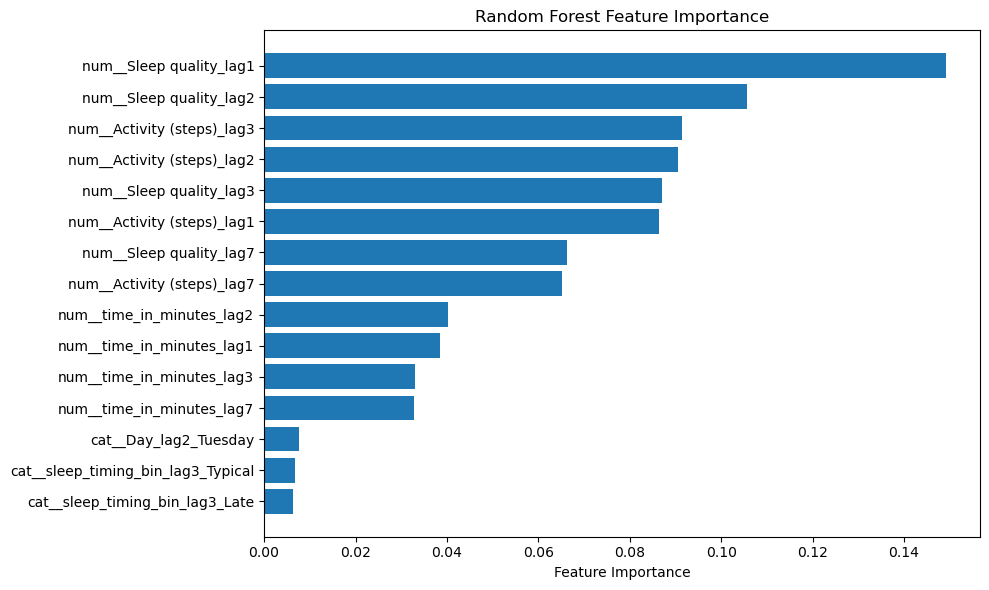

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"][:15], importance_df["importance"][:15])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

We see that lag features of sleep quality, activity steps, time in minutes day, and sleeping_timing_bin, in that order contribute to the prediction